## About this code

This script describes a pipeline for the pro/anti Israel classification algorithm.<br>
Input: training set of tweets<br>
Process: apply pre-process, feature engineering, modeling and classification (-1,0 or 1)<br>
Output: a classification per input. -1 is anti Israel, 0 neutral, 1 pro Israel.
1. Using the Pipeline.py for pre-process, feature engineering (NLP, entities, user features) and feature selection
2. Classification - 3 problems of 1 VS. all
3. Evaluation

# Table of Content

- <a href="#Run-configurations">Run configurations</a>
- <a href="#Data-import">Data import</a>
- <a href="#Run-pipeline">Run pipeline</a>
- <a href="#KDE-plots">KDE plots</a>
- <a href="#Running-Models">Running Models</a>
    - <a href="#Three-1-vs-All-problems">Three 1 vs All problems</a>
    - <a href="#Evaluation">Evaluation</a>
    - <a href="#Benchmark">Benchmark</a>
    - <a href="#One-Regression-problem">One Regression problem</a>

## Run configurations

<div class="alert alert-block alert-warning">
Pay attention to:<br>
    - load_df_from_pickle<br>
    - load_test_df_from_pickle<br>
    - load_model_pickle
</div>

In [1]:
config = {
            # Mode
            'learning': True,           # True at the train phase, False when operational - predict new data using existing model
        
            # Data
            'filter_taggers': False,    # If to filter labeled data by the tagger - Yogev, Ofir and Itay
            'target': 'support',        # The target of the algorithm
            'load_df_from_pickle': True, # If to load a complete data-frame or to execute the entire pipeline on the train set 
            'load_test_df_from_pickle': True,  # If to load a complete data-frame or to execute the entire pipeline on the test set 
            
            # Pre-process
            'slang': True,              # If to handle slang words, also for Feature engineering
            'spell_correction': False,  # If to use spell correction in the pre-proccess phase 
            'col': 'text',              # Column to apply pre-proccess on - used by the proccess_tweet function in tweet_pre_proccess.py
            
            # Feature engineering
            'nlp_features': True,
            'word_type': True,
            'dominant_keywords': True,
            'dominant_keywords_metric': 'entropy', # entropy, purity, smart_error
            'user_features': False,
            'user_bio': True,
            'time_and_event': True,    # Time and event features
            'twitter_foundation_date': '2006-03-21 12:00:00',
            'network_features': False,
            'load_network_data': False,
            'nlp_raw': True,
            'emotion': True,
            'hashtags_and_mentions': True,
            'num_dominant_words': 125,  # Number of dominant words to use in the NLP features (dominant_keywords function - parameter k)
            'min_word_appearances': 20,# Min number of appearnces (#tweets) for dominant word to be considered dominant
            'min_couple_appearances': 20,# For couple of dominant words -
                                        # how many time the combination need to appear in the data in order to become a feature        
            'url_features': False,
            'Tweets_media_and_content': True,
            'country_support': True,
            'entities_features': True,
            'sentiment': True,          # NLTK sentiment feature
    
            # Feature selection
            'feature_selection': True,
            'remove_features_zero_variance': False,        
            'remove_correlated_features': False,
            'remove_low_correlated_features': False,
            'feature_importance': True,
            'corr_per_thresh': 0.0,    # Percentile threshold of Min correlation between a feature and the target variable (abs) 
            'importance_per_thresh': 70,# Percentile threshold of Min importance of a feature , 33
            'PCA': False,               # If the use PCA to reduce dimensiality
            'PCA_var': 0.995,           # % of commulative explained variance required from PCA (affect #of PC)

            # Model
            'model': 'ALL', 
            'load_model_pickle': False, # If to import existing models from pickle
            'regression': False,        # If to run regression model also
            'validation': False,        # If to use train split to train and validation
            'iterate_class_thresholds': False, # If True - perform a grid search over the class_thresholds, for the 3-one-vs-all algorithm (the big algo)
                                        # If False - run the specific parameters that in this config - class_threshold
            'class_thresholds': [0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.55,0.6,0.7,0.8],
            'class_threshold': 0.0,     # Probability threshold in order to classify a tweet as negative/neurtal/positive
            'bench_from_pickle': True
    }

Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import os
import glob
import csv
import time
import matplotlib
import pickle
from tqdm import tqdm, trange, tqdm_notebook, tqdm_pandas
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

In [3]:
# Avoid trimming text in jupyter preview
pd.set_option('display.max_colwidth', -1)

In [4]:
#plt.style.use('ggplot')
%matplotlib inline

In [5]:
np.random.seed = 1234
tqdm.pandas(tqdm_notebook())

#### Import thesis modules

In [6]:
os.chdir('../pipeline')
import domain_entities
import nlp_url_features
import tweet_pre_proccess
import nlp_features
import eda
import ml_model
import slang
import pipeline
os.chdir('../{} algo'.format(config['target']))

## Data import

#### Train set import 

In [7]:
labeled_data = pd.read_csv("../../data/classifiers/labeled_data.csv", header=0, encoding='utf-8')

In [8]:
# Filter bad taggers
#labeled_data = labeled_data[labeled_data.Tagger.isin(['ofir','yogev','Itay'])] if config['filter_taggers'] else labeled_data

In [9]:
# Select only relevant columns
data_tweets = labeled_data[['id','text','relevance','support','screen_name','created_at']]
data_tweets.reset_index()

# Remove tweets with no target label
data_tweets = data_tweets.dropna(subset=[config['target']])

if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    data_tweets = data_tweets[(data_tweets['relevance']!=2) & (data_tweets['support']!='?')]
    del data_tweets['relevance']
else:
    data_tweets['relevance'] = data_tweets['relevance'].apply(lambda x: int(x))

In [10]:
print('Total number of rows in train set',data_tweets.shape[0])

Total number of rows in train set 5972


In [11]:
# data_tweets = data_tweets.drop_duplicates(subset=['id','screen_name','text'], keep='first')
print('Final number of unique Tweets:',data_tweets.shape[0])
print(' - unique Tweets by text:',data_tweets.drop_duplicates(subset=['text'], keep='first').shape[0])

Final number of unique Tweets: 5972
 - unique Tweets by text: 4077


In [12]:
data_tweets.head(n=1)

,id,text,support,screen_name,created_at
0,4.030000e+17,"""Join Students for Justice in Palestine (SJP UMN) this Wednesday at 4:30 pm with Josh Ruebner. His book """"Shattered... http://fb.me/2FbldzgdgÂ¬â€ """,-1,ampminnesota,1384803626


#### Test set import

In [13]:
# Load csv
test_set = pd.read_csv('../../data/classifiers/test.csv', header=0, encoding='utf-8')
test_set = test_set[['id','text','relevance','support','screen_name','created_at']]

### Data balance

In [14]:
data_tweets.support = data_tweets.support.apply(lambda x: float(x))

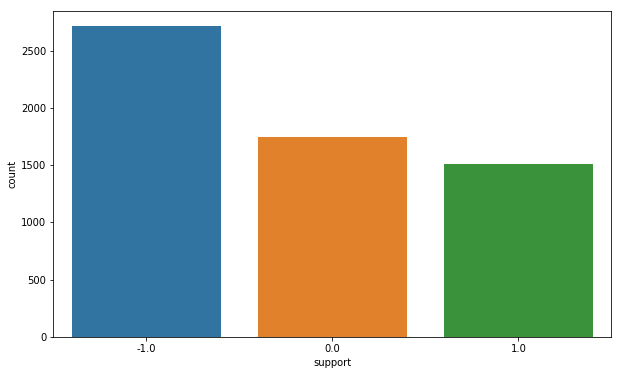

In [15]:
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
h = sns.countplot(x="support", data=data_tweets, order = data_tweets[config['target']].value_counts().index)

In [16]:
data_tweets.head(n=1)

,id,text,support,screen_name,created_at
0,4.030000e+17,"""Join Students for Justice in Palestine (SJP UMN) this Wednesday at 4:30 pm with Josh Ruebner. His book """"Shattered... http://fb.me/2FbldzgdgÂ¬â€ """,-1.0,ampminnesota,1384803626


## Run pipeline

#### Run pipeling

In [17]:
df = pipeline.pipeline(data_tweets, config) if not config['load_df_from_pickle'] else pd.read_pickle('../../data/classifiers/support_pipeline_train.pkl')

In [18]:
if not config['load_df_from_pickle']:
    df.to_pickle('../../data/classifiers/support_pipeline_train.pkl')

In [19]:
# Search for np.nan 
for col in df.columns:
    temp = df[col].apply(lambda x: 1 if x == np.nan else 0)
    print('{}: {}'.format(col, temp.sum())) if temp.sum() > 0 else None

### KDE plots

In [20]:
# labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
#           'relevance': {'names': ['Not relevant', 'Relevant', 'Ignore'], 'values': [0,1,2]}}

# features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'tokenized_text'])]
# eda.kde_plots(df, features, config['target'], labels[config['target']]['names'])

<div class="alert alert-block alert-info">
Useful features: <br>
    - PRP$ - perfect seperation for med-high values <br>
    - TO is neutral for hight values <br>
    - RBR is negative for high values <br>
    - WRB has ranges for anti and neutral <br>
</div>

## Running Models

In [21]:
# Updated features list
features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'id', 'tokenized_text', 'screen_name','created_at'])]

Export final feature list (after feature selection) to pickle.<br>
These features will be applied to new data at the production phase.

In [22]:
with open('{}_features_list.pickle'.format(config['target']), 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# All models configurations
model_objects = {'Random Forest': RandomForestClassifier,
                 'Naive Bayes': GaussianNB,
                 'Logistic Regression': LogisticRegression,
                 'SVM':SVC
                }

model_stats = {
                 'Random Forest': {},
                 'SVM':{},
                 'Naive Bayes': {},
                 'Logistic Regression': {},
                 'XGBoost':{},
                 'LightGBM': {}
                }

tuned_parameters_set = {'Random Forest': {'min_samples_split':[5,7], 'max_depth':[5,10,12,15,25],'criterion':['gini', 'entropy'], #15
                                           'n_estimators':[100,250,500,1000], 'random_state':[1], 'n_jobs':[-1] #n_estimators=500
                                         },
                        'SVM': {'C':[0.1], 'kernel':['linear'], 'random_state':[1],
                                 'gamma':[0.1, 1, 10], 'cache_size': [6000], 'probability': [True]
                                },
                        'Naive Bayes': {'priors': [x / sum(list(df.support.value_counts())) for x in list(df.support.value_counts())]},
                        'Logistic Regression': {'penalty': ["l2"], #What is our loss function? l2 stands for quad_distances, l1 stands for abs distance.
                             'dual': [False], #How to define our objective function, as the primal or the dual?
                             'tol': [0.0001], #Stopping critiria
                             'C': [0.1,1,10], #Inverse regularization parameter, large C means less regularization.
                             'fit_intercept': [True], #As it sounds, do we want to learn an intercept?
                             'intercept_scaling': [1], #What is the initialization of the intercept parameter
                             'class_weight': [None], #How to treat different classes?
                             'random_state': [1], #The seed
                             'solver': ["liblinear"], #What is the algorithm used to solve the problem?
                             'max_iter': [100], #For some optimization algorithms, the algorithm solves it with iterations.
                             #'multi_class': ["ovr"], #How to treat multiclass problems, doesn't matter for our course.
                             'verbose': [2], 
                             'warm_start': [False], 
                             'n_jobs':[1]},
                        
                         'XGBoost': { 'grid_params': {
                                                    'max_depth': [6,7,8,15,20],
                                                    'n_estimators': [100,250], # Number of trees
                                                    'booster': ['gbtree'], # ,'dart'],
                                                    #'learning_rate': [0.1, 0.15, 0.2, 0.3], # default 0.3
                                                         # Step size shrinkage used in update to prevents overfitting. 
                                                         # After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
                                                    #'gamma': [1,1.5,2,4], 
                                                         # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                                                    'colsample_bytree': [0.2,0.3,0.5,0.75,0.8], 
                                                         # Subsample ratio of columns when constructing each tree. Subsampling will occur once in every boosting iteration.
                                                    'subsample': [0.85,0.9],
                                                        # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 
                                                        # This will prevent overfitting. Subsampling will occur once in every boosting iteration.    
                                                    # 'reg_lambda': [1,5,10], # L2 regularization term on weights
                                                    # 'reg_alpha':[0,0.5,1],   # L1 regularization term on weight
                                                    # 'min_child_weight': [1.25,1.5,1.75,2,3],
                                                         # Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. 
                                                         # Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
                                     },
                                         'model_params': {
                                                    'objective': ['multi:softmax'], # multi:softmax, multi:softprob
                                                    'num_class': 3,
                                                    'eval_metric': ['mlogloss'] #,'merror']
                                                     # mlogloss - more punishment when classifier mistaken when was condident
                                        }
                                     },
                         'LightGBM': {
                                    'objective': ['multiclass','multiclassova'],
                                     # multiclassova: every classifier_i only learning that sample could seprated from class_i and class_rest
                                     # muticlass: every classfier_i could learning that sample could seprated the probality over all classes. (it's not accurate acctually)
                                    'num_class':[3],
                                    'boosting': ['gbdt'], #,'dart'],
                                    'feature_fraction': [0.1,0.2,0.3,0.35,0.4,0.5], # if you set it to 0.8, LightGBM will select 80% of features before training each tree
                                    'n_estimators': [100,250,500],
                                    'bagging_freq': [2,3,4,5],
                                    'learning_rate': [0.15, 0.2, 0.25, 0.3],
                                    'max_depth': [5,6,7,8]
                                    #'num_leaves': [30,50,75]
                                    # 'verbose': [0], # prints
                                   }
    }

normalizations = {'Random Forest': [False, False], # If to normalize, normalization type
                 'SVM':[True, 'Scaling'],
                 'Naive Bayes': [True, 'Scaling'],
                 'Logistic Regression': [True, 'Scaling']}

### Train-test split
#### Change configurations for test set build 
Test set does not need any filters or feature selection. From all features, we will select those who used in the train set.

In [24]:
for attr in ['learning', 'feature_selection', 'remove_features_zero_variance', 'remove_correlated_features', 'remove_low_correlated_features', 'feature_importance']:
    config[attr] = False

config['min_word_appearances'], config['min_couple_appearances']= 0,0

In [25]:
# Remove tweets with no target label
test_set = test_set.dropna(subset=[config['target']])
if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    test_set = test_set[test_set['relevance']!=2]
else:
    test_set['relevance'] = test_set['relevance'].apply(lambda x: int(x))

In [26]:
# Run pipeline on test set
test_set = pipeline.pipeline(test_set, config) if not config['load_test_df_from_pickle'] else pd.read_pickle('../../data/classifiers/support_pipeline_test.pkl')

In [27]:
# Check no columns are missing in the test set
for col in df[features].columns:
    if col not in test_set.columns:
        print('Column {} is missing from the test set'.format(col))

In [28]:
if not config['load_test_df_from_pickle']:
    test_set.to_pickle('../../data/classifiers/support_pipeline_test.pkl')

In [29]:
df.reset_index(inplace=True)
test_set.reset_index(inplace=True)

#### Split to train and test, features and label

In [30]:
x_train, y_train, x_test, y_test = df[features], df[config['target']], test_set[features], test_set[config['target']]

Information regarding XGBoost and Light GBM:<br> 
https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

### One multiclass problem

#### XGBoost
Parameters docs: https://xgboost.readthedocs.io/en/latest/parameter.html

In [31]:
if config['model'] in ['XGBoost','ALL']:
    # Limit XGBoost resources to avoid crash
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    
    xgb_model, model_stats['XGBoost'] = ml_model.run_XGBoost(x_train, x_test, y_train, y_test, tuned_parameters_set['XGBoost'])
    xgb_model.save_model('../../data/classifiers/support_XGBoost.model')

In [32]:
if config['model']=='XGBoost' and config['iterate_class_thresholds']:
    # We want to run the ensembel model with different classification thresholds.
    class_thresholds_stats = {}
    for thresh in config['class_thresholds']:
        config['class_threshold'] = thresh
        xgb_test_results =  pd.DataFrame()
        xgb_predictions_test = xgb_model.predict_proba(x_test)
        label_converter = {-1: 0, 0: 1, 1: 2}
        Y_test = y_test.apply(lambda x: label_converter[x])
        for i in range(3):
            xgb_test_results[i] = xgb_predictions_test[:,i]
        xgb_test_results['max_prob'] = xgb_test_results.max(axis=1)
        xgb_test_results['prediction'] = xgb_test_results.iloc[:, :-1].idxmax(axis=1)
        xgb_test_results['true_value'] = Y_test.reset_index(drop=True)
        # Change predictions according to thresholds
        xgb_test_results['prediction'] = xgb_test_results[['max_prob', 'prediction']].apply(
            lambda x: x.prediction if x.max_prob > config['class_threshold'] else 'Unknown', axis=1)
        n_test = xgb_test_results.shape[0]
        xgb_test_results = xgb_test_results[xgb_test_results.prediction.isin([0,1,2])]
        accuracy = metrics.accuracy_score(list(xgb_test_results.true_value), list(xgb_test_results.prediction),
                              normalize=True)
        uncl_test = n_test-xgb_test_results.shape[0]
        uncl_test_XG = np.round(uncl_test/n_test,4)
        class_thresholds_stats[thresh] = {}
        class_thresholds_stats[thresh]['accuracy_test'] = accuracy
        class_thresholds_stats[thresh]['unclassified_test'] = uncl_test_XG
    x_tresh = list(class_thresholds_stats.keys())
    accuracy_treh = []
    unclassified_tresh = []
    for key in x_tresh:
        accuracy_treh.append(class_thresholds_stats[key]['accuracy_test'])
        unclassified_tresh.append(class_thresholds_stats[key]['unclassified_test'])
    fig = plt.figure(figsize=(10,8), dpi= 70)
    plt.plot(x_tresh,accuracy_treh)
    plt.plot(x_tresh,unclassified_tresh)
    plt.legend(['accuracy', 'unclassified tweets'], fontsize=12,ncol=1, loc='upper left',bbox_to_anchor=(1, 1))
    plt.title("Accuracy vs. Unclassified rate - Validation set", fontsize=22)
    plt.xlabel('Threshold', fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.show()

In [33]:
if config['model'] in ['XGBoost','ALL']:
    xgb_train_results =  pd.DataFrame()
    xgb_test_results =  pd.DataFrame()
    xgb_predictions_train = xgb_model.predict_proba(x_train)
    xgb_predictions_test = xgb_model.predict_proba(x_test)
    label_converter = {-1: 0, 0: 1, 1: 2}
    Y_train = y_train.apply(lambda x: label_converter[x])
    Y_test = y_test.apply(lambda x: label_converter[x])
    for i in range(3):
        xgb_train_results[i] = xgb_predictions_train[:,i]
        xgb_test_results[i] = xgb_predictions_test[:,i]
    xgb_train_results['max_prob'] = xgb_train_results.max(axis=1)
    xgb_train_results['prediction'] = xgb_train_results.iloc[:, :-1].idxmax(axis=1)
    xgb_test_results['max_prob'] = xgb_test_results.max(axis=1)
    xgb_test_results['prediction'] = xgb_test_results.iloc[:, :-1].idxmax(axis=1)
    xgb_train_results['true_value'] = Y_train.reset_index(drop=True)
    xgb_test_results['true_value'] = Y_test.reset_index(drop=True)
    # Change predictions according to thresholds
    xgb_train_results['prediction'] = xgb_train_results[['max_prob', 'prediction']].apply(
        lambda x: x.prediction if x.max_prob > config['class_threshold'] else 'Unknown', axis=1) 
    xgb_test_results['prediction'] = xgb_test_results[['max_prob', 'prediction']].apply(
        lambda x: x.prediction if x.max_prob > config['class_threshold'] else 'Unknown', axis=1)
    n_train, n_test = xgb_train_results.shape[0], xgb_test_results.shape[0]
    xgb_train_results = xgb_train_results[xgb_train_results.prediction.isin([0,1,2])]
    xgb_test_results = xgb_test_results[xgb_test_results.prediction.isin([0,1,2])]
    uncl_train, uncl_test = n_train-xgb_train_results.shape[0], n_test-xgb_test_results.shape[0]
    print(f'Unclassified tweets: train-{uncl_train}, test-{uncl_test}')

In [34]:
if config['model'] in ['XGBoost','ALL']:
    # Evaluate
    labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [0, 1, 2]},
              'relevance': {'names': ['Not relevant', 'Relevant', 'Ignore'], 'values': [0, 1, 2]}}
    ml_model.plot_confusion_matrix(list(xgb_train_results.prediction), list(xgb_train_results.true_value), '{} SUMMARY'.format(config['model']),
                                   'train', labels[config['target']])
    ml_model.plot_confusion_matrix(list(xgb_test_results.prediction), list(xgb_test_results.true_value), '{} SUMMARY'.format(config['model']), 'test',
                                   labels[config['target']])

    # Calculate accuracy
    accuracy_train = metrics.accuracy_score(list(xgb_train_results.true_value), list(xgb_train_results.prediction),
                                            normalize=True)
    accuracy = metrics.accuracy_score(list(xgb_test_results.true_value), list(xgb_test_results.prediction),
                                      normalize=True)
    print('############################################################################')
    print('accuracy_train: ', accuracy_train, '\naccuracy_test: ', accuracy, '\nunclassified_train: ', np.round(uncl_train/n_train,4),
          '\nunclassified_test: ' ,np.round(uncl_test/n_test,4))
    
    accuracy_train_XG = accuracy_train
    accuracy_XG = accuracy
    uncl_train_XG = np.round(uncl_train/n_train,4)
    uncl_test_XG = np.round(uncl_test/n_test,4)
    
    # Ploting
    from xgboost import plot_importance
    # feature importance
    # plot feature importance
    ax = plot_importance(xgb_model, importance_type='weight', max_num_features=15,
                        show_values=False)
    fig = ax.figure
    fig.set_size_inches(12,8)
    plt.title('Feature importance (XGBoost)', fontsize=18)
    plt.xlabel('Score (number of times feature appears in a tree)', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.yticks(fontsize=12)
    plt.show()
    fig.savefig('../../data/predictions/XGBoost_support_feature_importance.png',bbox_inches = 'tight')

#### Light GBM
Parameters docs: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [35]:
if config['model'] in ['LightGBM','ALL']:
    lgbm_model, model_stats['LightGBM'] = ml_model.run_LightGBM(x_train, x_test, y_train, y_test, tuned_parameters_set['LightGBM'])

In [36]:
if config['model'] in ['LightGBM','ALL']:
    GBM_train_results =  pd.DataFrame()
    GBM_test_results =  pd.DataFrame()
    GBM_predictions_train = lgbm_model.predict_proba(x_train)
    GBM_predictions_test = lgbm_model.predict_proba(x_test)
    label_converter = {-1: 0, 0: 1, 1: 2}
    Y_train = y_train.apply(lambda x: label_converter[x])
    Y_test = y_test.apply(lambda x: label_converter[x])
    for i in range(3):
        GBM_train_results[i] = GBM_predictions_train[:,i]
        GBM_test_results[i] = GBM_predictions_test[:,i]
    GBM_train_results['max_prob'] = GBM_train_results.max(axis=1)
    GBM_train_results['prediction'] = GBM_train_results.iloc[:, :-1].idxmax(axis=1)
    GBM_test_results['max_prob'] = GBM_test_results.max(axis=1)
    GBM_test_results['prediction'] = GBM_test_results.iloc[:, :-1].idxmax(axis=1)
    GBM_train_results['true_value'] = Y_train.reset_index(drop=True)
    GBM_test_results['true_value'] = Y_test.reset_index(drop=True)
    # Change predictions according to thresholds
    GBM_train_results['prediction'] = GBM_train_results[['max_prob', 'prediction']].apply(
        lambda x: x.prediction if x.max_prob > config['class_threshold'] else 'Unknown', axis=1)
    GBM_test_results['prediction'] = GBM_test_results[['max_prob', 'prediction']].apply(
        lambda x: x.prediction if x.max_prob > config['class_threshold'] else 'Unknown', axis=1)
    n_train, n_test = GBM_train_results.shape[0], GBM_test_results.shape[0]
    GBM_train_results = GBM_train_results[GBM_train_results.prediction.isin([0,1,2])]
    GBM_test_results = GBM_test_results[GBM_test_results.prediction.isin([0,1,2])]
    uncl_train, uncl_test = n_train-GBM_train_results.shape[0], n_test-GBM_test_results.shape[0]
    print(f'Unclassified tweets: train-{uncl_train}, test-{uncl_test}')

In [37]:
if config['model'] in ['LightGBM','ALL']:
    # Evaluate
    labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [0, 1, 2]},
              'relevance': {'names': ['Not relevant', 'Relevant', 'Ignore'], 'values': [0, 1, 2]}}
    ml_model.plot_confusion_matrix(list(GBM_train_results.prediction), list(GBM_train_results.true_value), '{} SUMMARY'.format(config['model']),
                                   'train', labels[config['target']])
    ml_model.plot_confusion_matrix(list(GBM_test_results.prediction), list(GBM_test_results.true_value), '{} SUMMARY'.format(config['model']), 'test',
                                   labels[config['target']])

    # Calculate accuracy
    accuracy_train = metrics.accuracy_score(list(GBM_train_results.true_value), list(GBM_train_results.prediction),
                                            normalize=True)
    accuracy = metrics.accuracy_score(list(GBM_test_results.true_value), list(GBM_test_results.prediction),
                                      normalize=True)
    print('############################################################################')
    print('accuracy_train: ', accuracy_train, '\naccuracy_test: ', accuracy, '\nunclassified_train: ', np.round(uncl_train/n_train,4),
          '\nunclassified_test: ' ,np.round(uncl_test/n_test,4))
    
    accuracy_train_GBM = accuracy_train
    accuracy_GBM = accuracy
    uncl_train_GBM = np.round(uncl_train/n_train,4)
    uncl_test_GBM = np.round(uncl_test/n_test,4)

### Three 1 vs All problems

Best parameters are: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 1}
Model AUC: 0.910


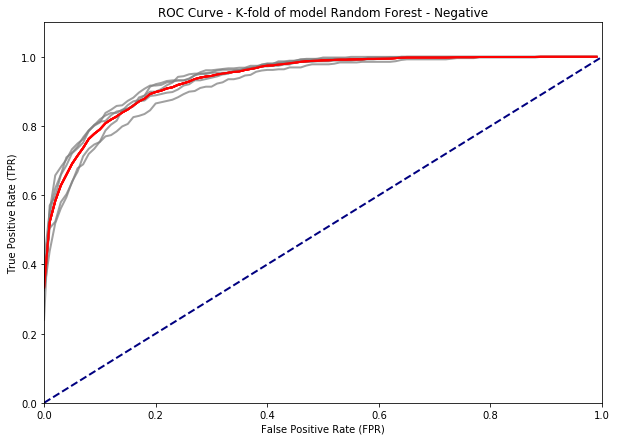

The average AUC over 5-folds is: 0.937
The average accuracy over 5-folds is: 85.18%
The MSE on the train set: 0.0280
The MSE on the test set: 0.1076


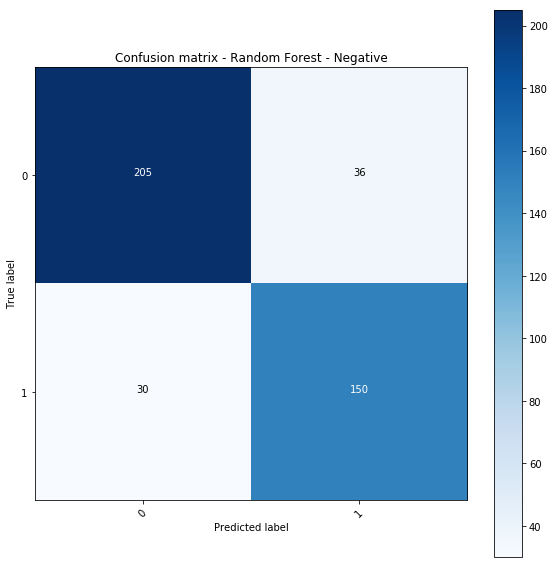

Accuracy on test: 0.84


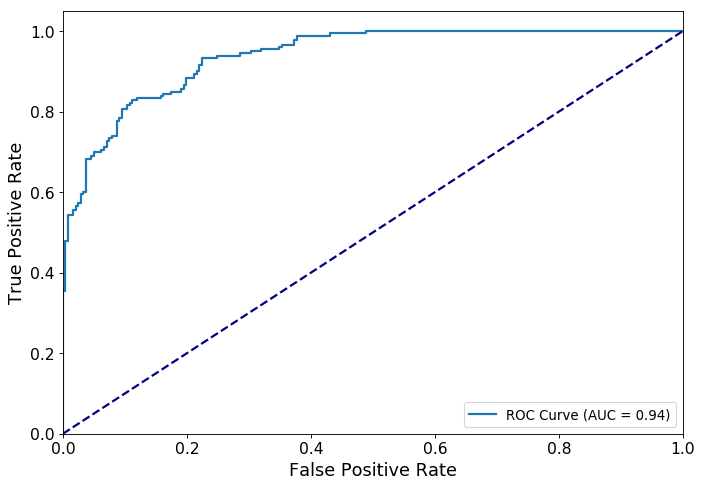

AUC achieved: 0.94
Best parameters are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 1}
Model AUC: 0.862


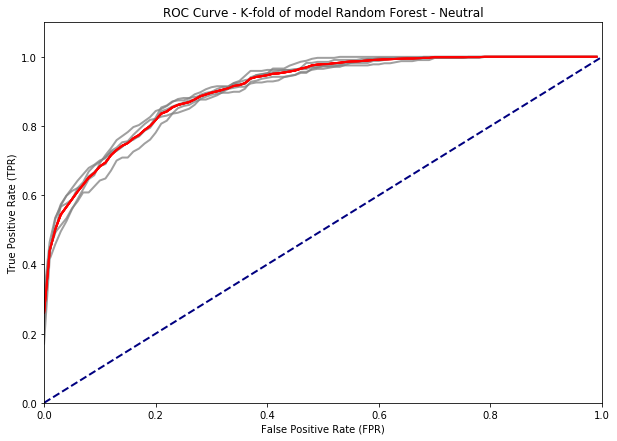

The average AUC over 5-folds is: 0.905
The average accuracy over 5-folds is: 84.24%
The MSE on the train set: 0.0333
The MSE on the test set: 0.1153


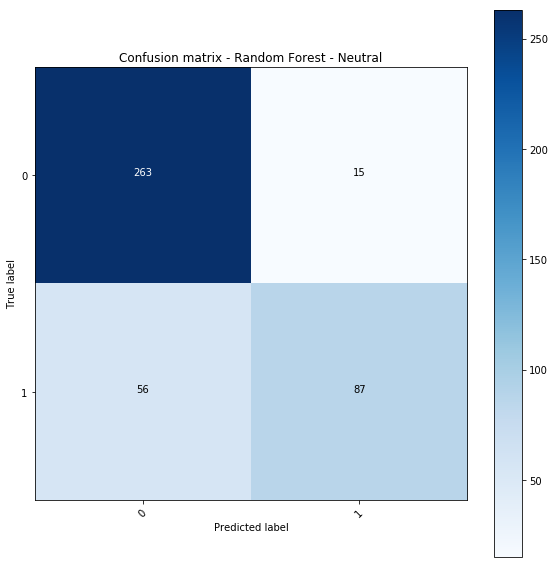

Accuracy on test: 0.83


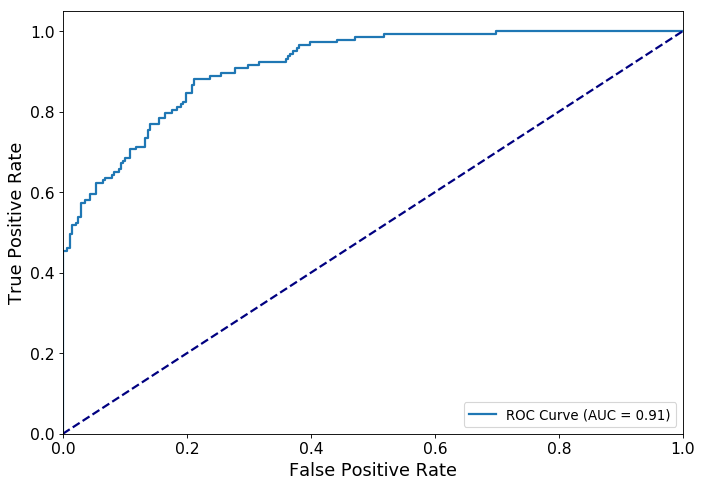

AUC achieved: 0.91
Best parameters are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 1}
Model AUC: 0.885


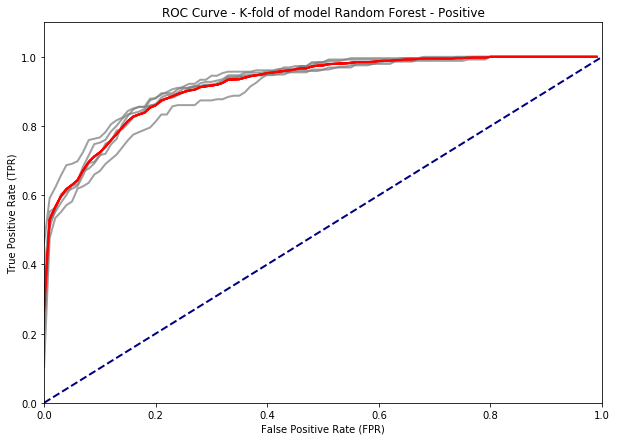

The average AUC over 5-folds is: 0.919
The average accuracy over 5-folds is: 88.14%
The MSE on the train set: 0.0240
The MSE on the test set: 0.0820


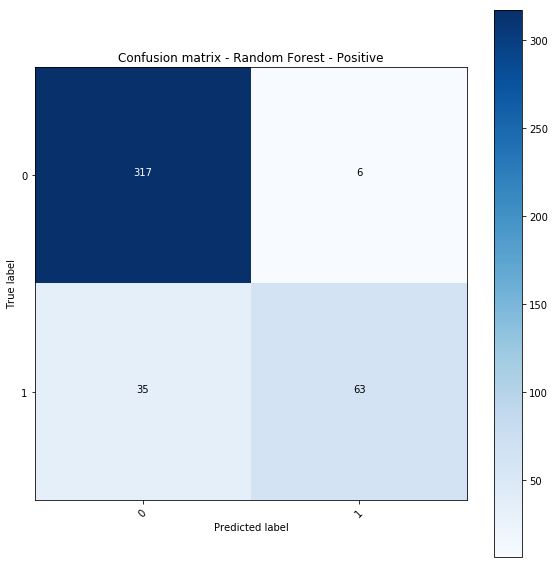

Accuracy on test: 0.90


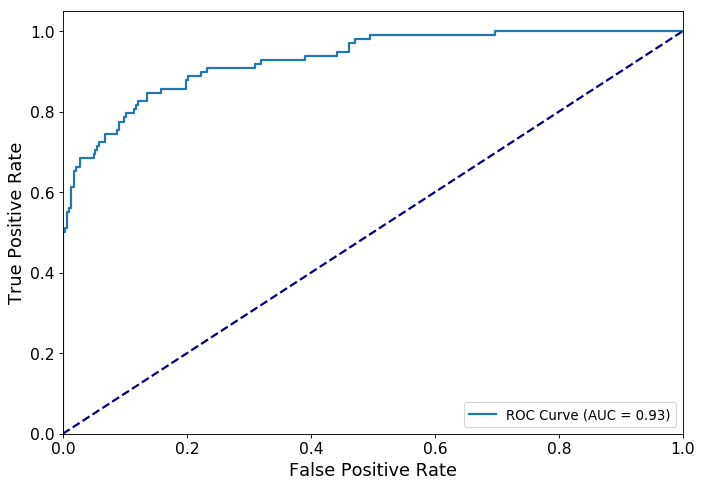

AUC achieved: 0.93
############################################################################
############################################################################
FINAL MODEL SUMMARY


In [46]:
if config['load_model_pickle']:
    with open('../../data/classifiers/support_models.pickle', 'rb') as handle:
        support_models = pickle.load(handle)
else:
    # Create a list that will holds the 3 models of 1 vs All
    support_models = {}
    classes = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
    
    if config['model'] == 'ALL':
        # Iterate over all models
        for ml_model_name in model_objects:
            pipeline.print_seperator()
            print('MODEL:', ml_model_name)
            # Set the current model and the parmeters grid to be checked
            config['model'], tuned_parameters = ml_model_name, tuned_parameters_set[ml_model_name]
            
            # Normalize the data
            if normalizations[config['model']][0]: # If normalization is required
                cur_x_train, columns_data = ml_model.normalize(x_train, normalizations[config['model']][1])
                cur_x_test = ml_model.normalize(x_test, normalizations[config['model']][1], columns_data)
            else:
                cur_x_train, cur_x_test = x_train, x_test
                
            # Iterate over all models
            config['model'] = ml_model_name
            for relevant_class in classes:
                # Choose the model object
                model_obj = model_objects[config['model']]
                # Run model
                if ml_model_name=='Naive Bayes': # Choose relevant prior: [tuned_parameters[relevant_class],1-tuned_parameters[relevant_class]]
                    support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, cur_x_train, cur_x_test, y_train, y_test, [1-tuned_parameters['priors'][relevant_class],tuned_parameters['priors'][relevant_class]], 5, 'roc_auc', True, True)
                else:
                    # (model_object, model name, relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, num of k fold, target metric, check_on_test)
                    support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, cur_x_train, cur_x_test, y_train, y_test, tuned_parameters, 5, 'roc_auc', True, True)

            # Save models (3 models) in a pickle file
            with open('../../data/classifiers/support_models_{}.pickle'.format(config['model']), 'wb') as handle:
                pickle.dump(support_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            # Evaluation
            pipeline.print_seperator()
            print('MODEL {} SUMMARY'.format(ml_model_name))
            model_stats[ml_model_name]['summary'] = ml_model.evaluate_multi_class_algo(cur_x_train, y_train, cur_x_test, y_test, support_models, config)
    
    elif config['model'] not in ['LightGBM','XGBoost']: # Run specific model
        
        if config['model']=='Random Forest' and config['iterate_class_thresholds']:
            # We want to run the ensembel model with different classification thresholds.
            class_thresholds_stats = {}
            for thresh in config['class_thresholds']:
                config['class_threshold'] = thresh
                model_stats = {
                 'Random Forest': {},
                 'SVM':{},
                 'Naive Bayes': {},
                 'Logistic Regression': {},
                 'XGBoost':{},
                 'LightGBM': {}
                }
                
                # Parmeters grid to be checked
                tuned_parameters = tuned_parameters_set[config['model']]
                if normalizations[config['model']][0]: # Normalization is required
                    # Remove categorical features
                    x_train, x_test = ml_model.remove_categorical_features(x_train), ml_model.remove_categorical_features(x_test)
                    # Normalize the data
                    x_train, columns_data = ml_model.normalize(x_train, normalizations[config['model']][1])
                    x_test = ml_model.normalize(x_test, normalizations[config['model']][1], columns_data)

                for relevant_class in classes:
                    # Choose the model object
                    model_obj = model_objects[config['model']]
                    # Run model
                    if config['model']=='Naive Bayes':
                        # Choose relevant prior: [tuned_parameters[relevant_class],1-tuned_parameters[relevant_class]]
                        support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, x_train, x_test, y_train, y_test, [1-tuned_parameters['priors'][relevant_class],tuned_parameters['priors'][relevant_class]], 5, ['accuracy', 'roc_auc'], True, True)
                    else:
                        # (model_object, model name, relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, num of k fold, target metric, check_on_test)
                        support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, 5, 'roc_auc', True, True)

                # Save models in a pickle file
                with open('../../data/classifiers/support_models.pickle', 'wb') as handle:
                    pickle.dump(support_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

                pipeline.print_seperator(2)
                print('FINAL MODEL SUMMARY')
                # Evaluation
                model_stats[config['model']] = ml_model.evaluate_multi_class_algo(x_train, y_train, x_test, y_test, support_models, config)
                class_thresholds_stats[thresh] = model_stats[config['model']]
                del model_stats[config['model']]
                
        else:
            # Parmeters grid to be checked
            tuned_parameters = tuned_parameters_set[config['model']]
            if normalizations[config['model']][0]: # Normalization is required
                # Remove categorical features
                x_train, x_test = ml_model.remove_categorical_features(x_train), ml_model.remove_categorical_features(x_test)
                # Normalize the data
                x_train, columns_data = ml_model.normalize(x_train, normalizations[config['model']][1])
                x_test = ml_model.normalize(x_test, normalizations[config['model']][1], columns_data)

            for relevant_class in classes:
                # Choose the model object
                model_obj = model_objects[config['model']]
                # Run model
                if config['model']=='Naive Bayes':
                    # Choose relevant prior: [tuned_parameters[relevant_class],1-tuned_parameters[relevant_class]]
                    support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, x_train, x_test, y_train, y_test, [1-tuned_parameters['priors'][relevant_class],tuned_parameters['priors'][relevant_class]], 5, ['accuracy', 'roc_auc'], True, True)
                else:
                    # (model_object, model name, relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, num of k fold, target metric, check_on_test)
                    support_models[relevant_class], model_stats[config['model']][relevant_class] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[relevant_class]), relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, 5, 'roc_auc', True, True)

            # Save models in a pickle file
#             with open('../../data/classifiers/support_models.pickle', 'wb') as handle:
#                 pickle.dump(support_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # Save models in a pickle file
#             with open('../../data/classifiers/support_models_{}.pickle'.format(config['model']), 'wb') as handle:
#                 pickle.dump(support_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

            pipeline.print_seperator(2)
            print('FINAL MODEL SUMMARY')
            # Evaluation
            model_stats[config['model']] = ml_model.evaluate_multi_class_algo(x_train, y_train, x_test, y_test, support_models, config)

In [38]:
with open('../../data/classifiers/support_models_Random Forest.pickle', 'rb') as handle:
    model = pickle.load(handle)

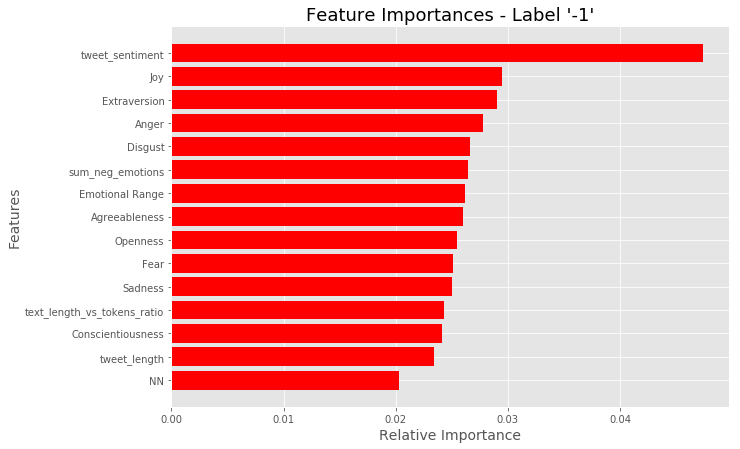

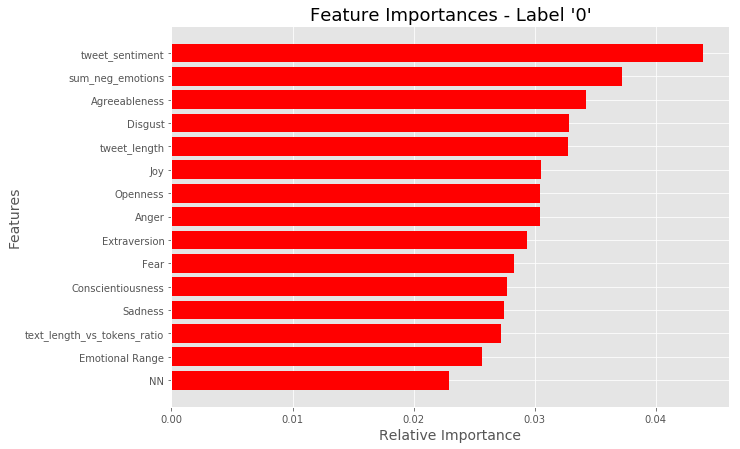

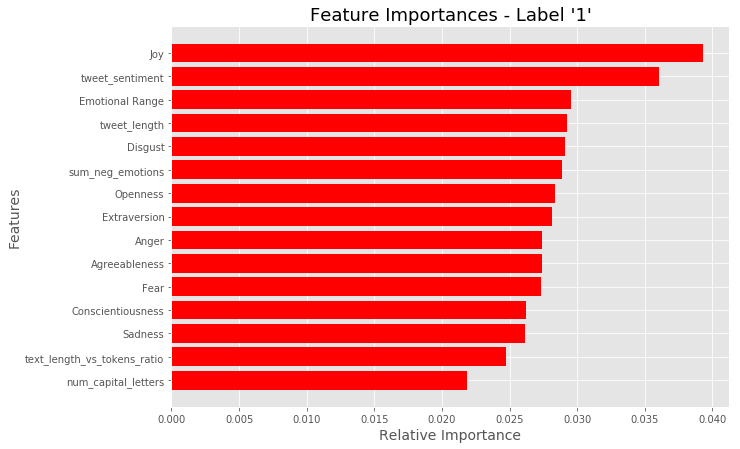

In [41]:
for forest in model:
    # Get the feature's importance
    importances_basic = model[forest].feature_importances_
    indices = np.argsort(importances_basic)[-15:]

    # Plot the feature importances
    plt.figure(figsize=(10, 7))
    plt.title("Feature Importances - Label '{}'".format(forest),fontsize=18)
    plt.barh(range(len(indices)), importances_basic[indices], 
            color="red", align="center")

    plt.ylabel('Features',fontsize=14)
    plt.xlabel('Relative Importance',fontsize=14)
    plt.yticks(range(len(indices)), x_train.columns[indices])
    plt.show()

In [42]:
if config['model']=='Random Forest' and config['iterate_class_thresholds']:
    x_tresh = list(class_thresholds_stats.keys())
    accuracy_treh = []
    unclassified_tresh = []
    for key in x_tresh:
        accuracy_treh.append(class_thresholds_stats[key]['accuracy_test'])
        unclassified_tresh.append(class_thresholds_stats[key]['unclassified_test'])
    fig = plt.figure(figsize=(10,8), dpi= 70)
    plt.plot(x_tresh,accuracy_treh)
    plt.plot(x_tresh,unclassified_tresh)
    plt.legend(['accuracy', 'unclassified tweets'], fontsize=12,ncol=1, loc='upper left',bbox_to_anchor=(1, 1))
    plt.title("Accuracy vs. Unclassified rate - Validation set", fontsize=22)
    plt.xlabel('Threshold', fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.show()

In [43]:
if config['model'] in ['LightGBM','ALL']:
    model_stats['LightGBM']['summary']['accuracy_train'] = accuracy_train_GBM
    model_stats['LightGBM']['summary']['accuracy_test'] = accuracy_GBM
    model_stats['LightGBM']['summary']['unclassified_train'] = uncl_train_GBM
    model_stats['LightGBM']['summary']['unclassified_test'] = uncl_test_GBM
if config['model'] in ['XGBoost','ALL']:    
    model_stats['XGBoost']['summary']['accuracy_train'] = accuracy_train_XG
    model_stats['XGBoost']['summary']['accuracy_test'] = accuracy_XG
    model_stats['XGBoost']['summary']['unclassified_train'] = uncl_train_XG
    model_stats['XGBoost']['summary']['unclassified_test'] = uncl_test_XG

## Comparison

In [44]:
# # Export model_stats to sensitivity_tests folder - save only summary for each algo
# print(config['num_dominant_words'])
# model_stats_summary = pd.DataFrame.from_dict(model_stats, orient='index')
# model_stats_summary

### Accuracy comaprison

Of final model (3 classes)

In [36]:
model_stats['CNN-LSTM'] = {}
model_stats['CNN-LSTM']['summary'] = {}
model_stats['CNN-LSTM']['summary']['accuracy_train'] = 0.98
model_stats['CNN-LSTM']['summary']['accuracy_test'] = 0.63

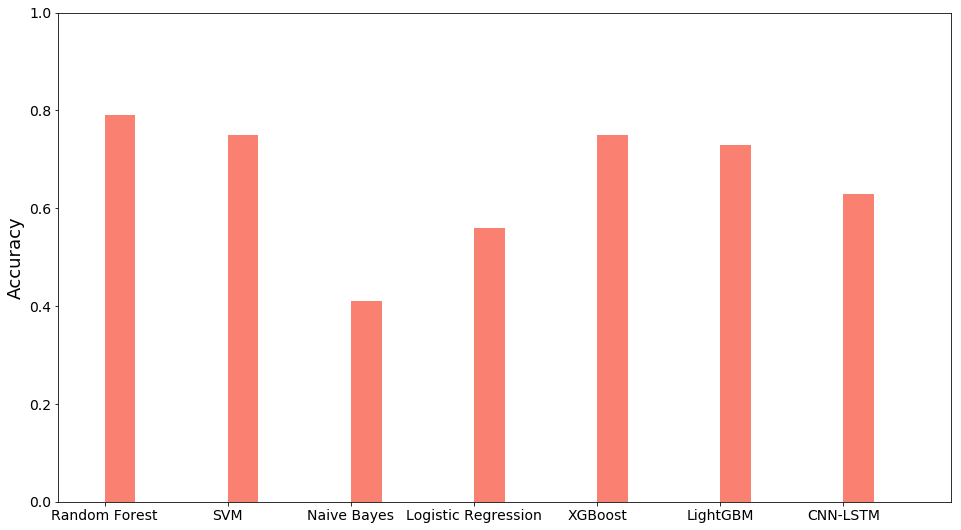

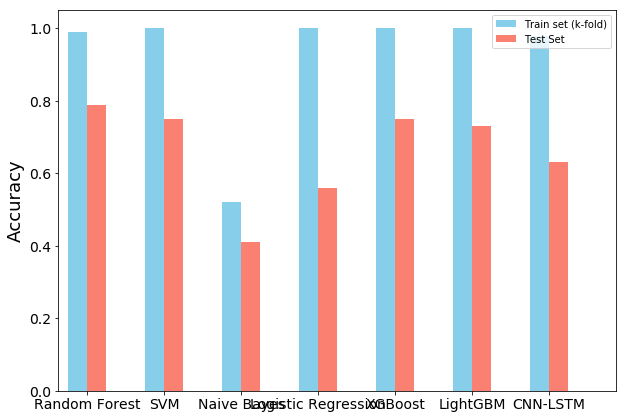

Highest accuracy achieved on train: 1.00
Highest accuracy achieved on test: 0.79
Highest accuracy achieved on test: 0.79


In [37]:
accuracy_test_lst = [model_stats[algo]['summary']['accuracy_test'] for algo in model_stats if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
bar_width = 0.5
adj_bars_space = bar_width
n_groups = len(accuracy_test_lst)

fig = plt.figure(figsize=(16,9))
accu_test_plot = plt.bar(np.arange(bar_width,bar_width+2*n_groups,2), accuracy_test_lst, width=bar_width, color='salmon')

#plt.title('Comparison - FINAL Accuracy')
plt.ylabel('Accuracy',fontsize=18)
#plt.xlabel('Model')
plt.xticks(np.arange(0.5*bar_width,bar_width+2*n_groups,2), [algo for algo in model_stats if 'summary' in model_stats[algo]])
plt.xlim([-0.5, 2*n_groups])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0,1])
plt.show()
fig.savefig('support_accuracy.png',bbox_inches='tight')
accuracy_train_lst = [model_stats[algo]['summary']['accuracy_train'] for algo in model_stats if 'summary' in model_stats[algo]]
accuracy_test_lst = [model_stats[algo]['summary']['accuracy_test'] for algo in model_stats if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
bar_width = 0.5
adj_bars_space = bar_width
n_groups = len(accuracy_train_lst)

plt.figure(figsize=(10,7))
accu_train_plot = plt.bar(np.arange(0,2*n_groups,2), accuracy_train_lst, width=bar_width, color='skyblue')
accu_test_plot = plt.bar(np.arange(bar_width,bar_width+2*n_groups,2), accuracy_test_lst, width=bar_width, color='salmon')

#plt.title('Comparison - FINAL Accuracy')
plt.ylabel('Accuracy',fontsize=18)
#plt.xlabel('Model')
plt.xticks(np.arange(0.5*bar_width,bar_width+2*n_groups,2), [algo for algo in model_stats if 'summary' in model_stats[algo]])
plt.xlim([-0.5, 2*n_groups])
#plt.ylim([0.7,0.77])
plt.legend([accu_train_plot, accu_test_plot], ['Train set (k-fold)', 'Test Set'], loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print('Highest accuracy achieved on train: {:.2f}'.format(max(accuracy_train_lst)))
print('Highest accuracy achieved on test: {:.2f}'.format(max(accuracy_test_lst)))
print('Highest accuracy achieved on test: {:.2f}'.format(max(accuracy_test_lst)))

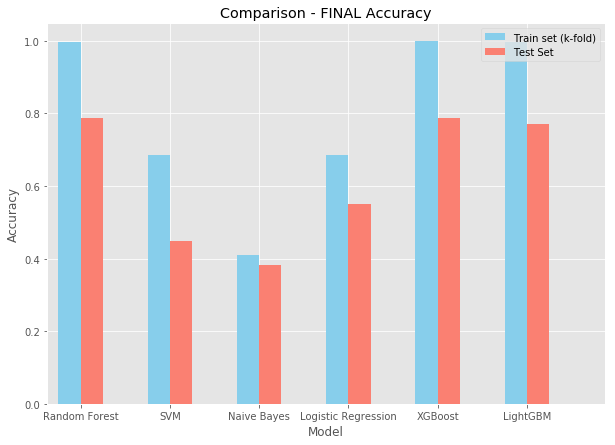

Highest accuracy achieved on train: 1.00
Highest accuracy achieved on test: 0.79


In [46]:
accuracy_train_lst = [model_stats[algo]['summary']['accuracy_train'] for algo in model_stats if 'summary' in model_stats[algo]]
accuracy_test_lst = [model_stats[algo]['summary']['accuracy_test'] for algo in model_stats if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
bar_width = 0.5
adj_bars_space = bar_width
n_groups = len(accuracy_train_lst)

plt.figure(figsize=(10,7))
accu_train_plot = plt.bar(np.arange(0,2*n_groups,2), accuracy_train_lst, width=bar_width, color='skyblue')
accu_test_plot = plt.bar(np.arange(bar_width,bar_width+2*n_groups,2), accuracy_test_lst, width=bar_width, color='salmon')

plt.title('Comparison - FINAL Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(np.arange(0.5*bar_width,bar_width+2*n_groups,2), [algo for algo in model_stats if 'summary' in model_stats[algo]])
plt.xlim([-0.5, 2*n_groups])
#plt.ylim([0.7,0.77])
plt.legend([accu_train_plot, accu_test_plot], ['Train set (k-fold)', 'Test Set'], loc='upper right')
plt.show()
print('Highest accuracy achieved on train: {:.2f}'.format(max(accuracy_train_lst)))
print('Highest accuracy achieved on test: {:.2f}'.format(max(accuracy_test_lst)))

### Adjusted accuracy comaprison

Neutral considered as 0.5 error.
Positive/Negative are 1.0 error in case of neutral tweet, and 1.5 error in case of the opposite.

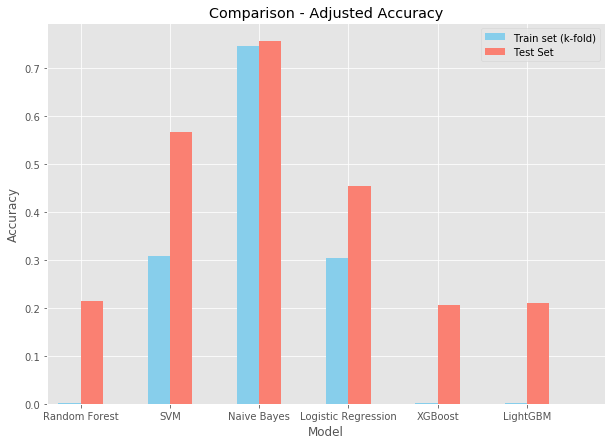

Lowest adj accuracy achieved on train: 0.00
Lowest adj accuracy achieved on test: 0.21


In [47]:
accuracy_train_lst = [model_stats[algo]['summary']['adj_accuracy_train'] for algo in model_stats 
                      if ('summary' in model_stats[algo] and 'adj_accuracy_train' in  model_stats[algo]['summary'])]
accuracy_test_lst = [model_stats[algo]['summary']['adj_accuracy_test'] for algo in model_stats 
                      if ('summary' in model_stats[algo] and 'adj_accuracy_test' in  model_stats[algo]['summary'])]

# Plot a bar plot of ausc on validation and test
bar_width = 0.5
adj_bars_space = bar_width
n_groups = len(accuracy_train_lst)

plt.figure(figsize=(10,7))
accu_train_plot = plt.bar(np.arange(0,2*n_groups,2), accuracy_train_lst, width=bar_width, color='skyblue')
accu_test_plot = plt.bar(np.arange(bar_width,bar_width+2*n_groups,2), accuracy_test_lst, width=bar_width, color='salmon')

plt.title('Comparison - Adjusted Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(np.arange(0.5*bar_width,bar_width+2*n_groups,2), [algo for algo in model_stats if 'summary' in model_stats[algo]])
plt.xlim([-0.5, 2*n_groups])
#plt.ylim([0.7,0.77])
plt.legend([accu_train_plot, accu_test_plot], ['Train set (k-fold)', 'Test Set'], loc='upper right')
plt.show()
print('Lowest adj accuracy achieved on train: {:.2f}'.format(min(accuracy_train_lst)))
print('Lowest adj accuracy achieved on test: {:.2f}'.format(min(accuracy_test_lst)))

#### Average AUC comparison

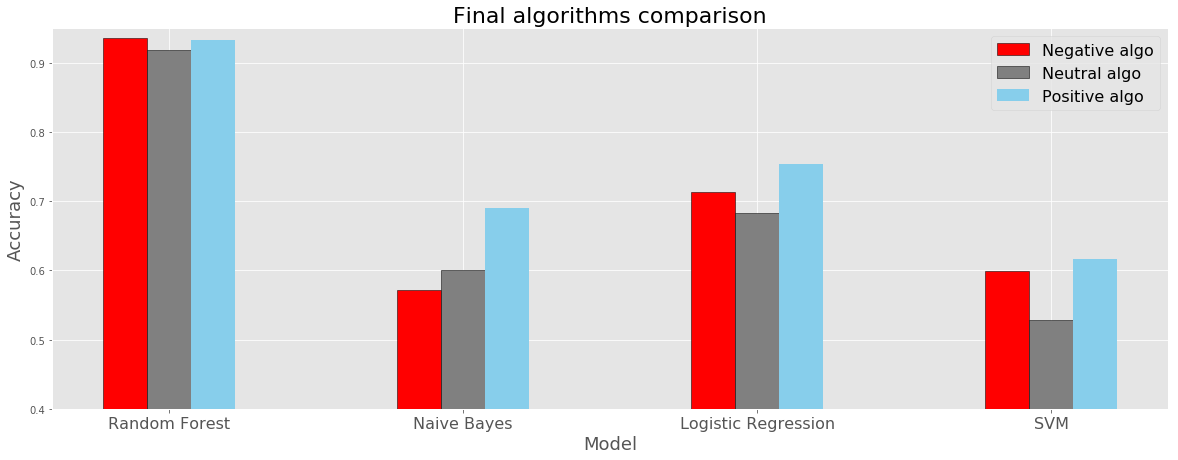

In [48]:
param = 'auc_test'
param_neg = [model_stats[algo][-1][param] for algo in model_objects if 'summary' in model_stats[algo]]
param_neutral = [model_stats[algo][0][param] for algo in model_objects if 'summary' in model_stats[algo]]
param_pos = [model_stats[algo][1][param] for algo in model_objects if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
plt.figure(figsize=(20,7))
bar_width = 0.15
n_groups = len(param_neg)

param_neg_plot = plt.bar(np.arange(0,n_groups), param_neg, width=bar_width, color='r',edgecolor='black')
param_neutral_plot = plt.bar(np.arange(bar_width,n_groups), param_neutral, width=bar_width, color='grey',edgecolor='black')
param_pos_plot = plt.bar(np.arange(2*bar_width,n_groups), param_pos, width=bar_width, color='skyblue')

plt.title('Final algorithms comparison', fontsize=22)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Model', fontsize=18)
plt.xticks(np.arange(bar_width,n_groups), [algo for algo in model_objects if 'summary' in model_stats[algo]], size=16)
#plt.xlim([-0.5, 1.0*n_groups])
plt.ylim([0.4,0.95])
plt.legend([param_neg_plot,param_neutral_plot,param_pos_plot], ['Negative algo', 'Neutral algo','Positive algo'], loc='upper right',fontsize=16)
plt.show()

#### Test accuray per label

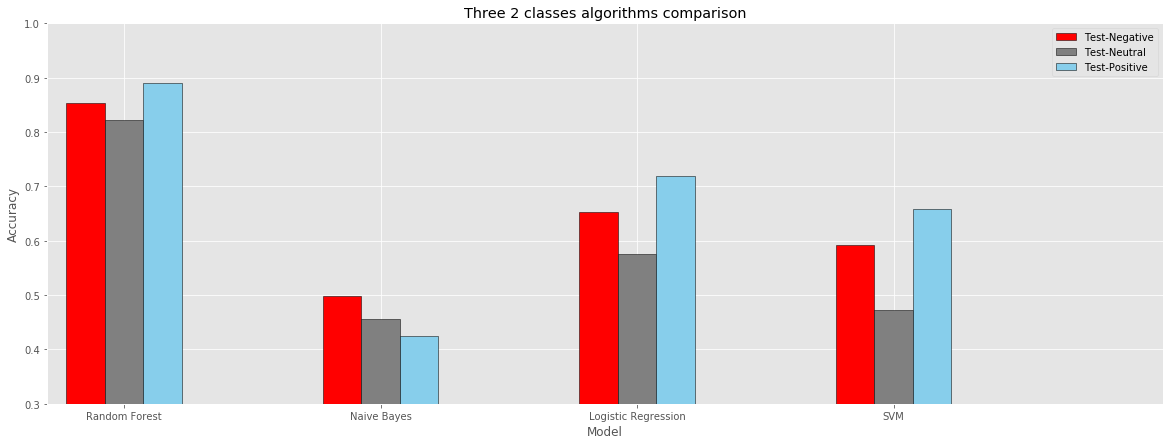

In [49]:
# param = 'accuracy_train'
# train_neg = [model_stats[algo][-1][param] for algo in model_objects if 'summary' in model_stats[algo]]
# train_neutral = [model_stats[algo][0][param] for algo in model_objects if 'summary' in model_stats[algo]]
# train_pos = [model_stats[algo][1][param] for algo in model_objects if 'summary' in model_stats[algo]]

param = 'accuracy_test'
test_neg = [model_stats[algo][-1][param] for algo in model_objects if 'summary' in model_stats[algo]]
test_neutral = [model_stats[algo][0][param] for algo in model_objects if 'summary' in model_stats[algo]]
test_pos = [model_stats[algo][1][param] for algo in model_objects if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
plt.figure(figsize=(20,7))
bar_width = 0.15

#train_neg_plot = plt.bar(np.arange(0,len(train_neg)), train_neg, width=bar_width, color='r', hatch='\\',edgecolor='black')
test_neg_plot = plt.bar(np.arange(0,len(test_neg)), test_neg, width=bar_width, color='r',edgecolor='black')

#train_neutral_plot = plt.bar(np.arange(2*bar_width,len(train_neutral)), train_neutral, width=bar_width, color='grey', hatch='\\',edgecolor='black')
test_neutral_plot = plt.bar(np.arange(1*bar_width,len(test_neutral)), test_neutral, width=bar_width, color='grey',edgecolor='black')

#train_pos_plot = plt.bar(np.arange(4*bar_width,len(train_pos)), train_pos, width=bar_width, color='skyblue', hatch='\\',edgecolor='black')
test_pos_plot = plt.bar(np.arange(2*bar_width,len(test_pos)), test_pos, width=bar_width, color='skyblue',edgecolor='black')

plt.title('Three 2 classes algorithms comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(np.arange(1.0*bar_width,len(test_neg)), [algo for algo in model_objects if 'summary' in model_stats[algo]])
plt.xlim([-bar_width, len(test_neg)+0.2])
plt.ylim([0.3,1.0])
# plt.legend([train_neg_plot,train_neutral_plot, train_pos_plot, 
#            test_neg_plot, test_neutral_plot, test_pos_plot], ['Train-Negative', 'Train-Neutral','Train-Positive','Test-Negative', 'Test-Neutral','Test-Positive'], loc='upper right')
plt.legend([test_neg_plot, test_neutral_plot, test_pos_plot], ['Test-Negative', 'Test-Neutral','Test-Positive'], loc='upper right')
plt.show()

#### Unclassified tweets comparison

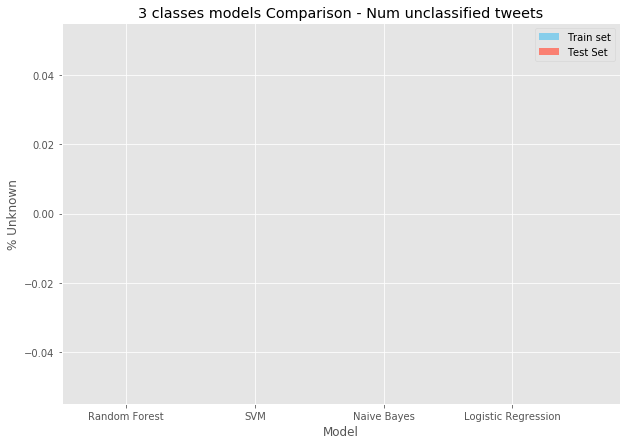

In [50]:
uncl_train = [model_stats[algo]['summary']['unclassified_train'] for algo in model_stats 
                      if ('summary' in model_stats[algo] and 'unclassified_train' in  model_stats[algo]['summary'])]
uncl_test = [model_stats[algo]['summary']['unclassified_test'] for algo in model_stats 
                      if ('summary' in model_stats[algo] and 'unclassified_test' in  model_stats[algo]['summary'])]

# Plot a bar plot of ausc on validation and test
plt.figure(figsize=(10,7))
uncl_train_plot = plt.bar(np.arange(0,1.5*len(uncl_train),1.5), uncl_train, width=0.5, color='skyblue')
uncl_test_plot = plt.bar(np.arange(0.5,0.5+1.5*len(uncl_test),1.5), uncl_test, width=0.5, color='salmon')

plt.title('3 classes models Comparison - Num unclassified tweets')
plt.ylabel('% Unknown')
plt.xlabel('Model')
plt.xticks(np.arange(0.25,1.5*len(uncl_train),1.5),
           [algo for algo in model_stats if ('summary' in model_stats[algo] and 'unclassified_test' in  model_stats[algo]['summary'])])
plt.xlim([-0.5, 1.5*len(uncl_train)])
#plt.ylim([0.7,0.77])
plt.legend([uncl_train_plot, uncl_test_plot], ['Train set', 'Test Set'], loc='upper right')
plt.show()

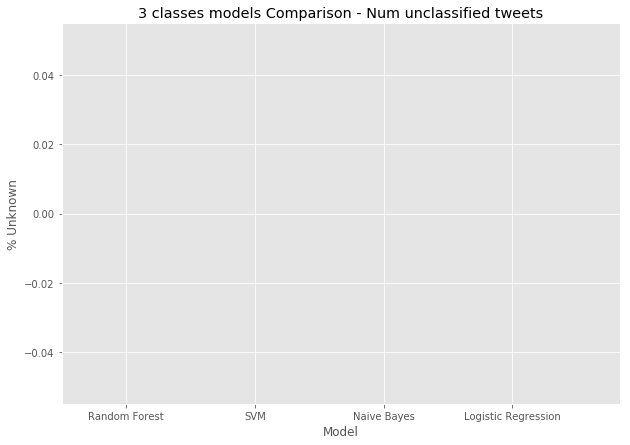

In [51]:
uncl_test = [model_stats[algo]['summary']['unclassified_test'] for algo in model_stats 
                      if ('summary' in model_stats[algo] and 'unclassified_test' in  model_stats[algo]['summary'])]

# Plot a bar plot of ausc on validation and test
plt.figure(figsize=(10,7))
uncl_test_plot = plt.bar(np.arange(0.5,0.5+1.5*len(uncl_test),1.5), uncl_test, width=0.5, color='salmon')

plt.title('3 classes models Comparison - Num unclassified tweets')
plt.ylabel('% Unknown')
plt.xlabel('Model')
plt.xticks(np.arange(0.25,1.5*len(uncl_train),1.5),
           [algo for algo in model_stats if ('summary' in model_stats[algo] and 'unclassified_test' in  model_stats[algo]['summary'])])
plt.xlim([-0.5, 1.5*len(uncl_train)])
#plt.ylim([0.7,0.77])
plt.show()

#### MSE comparison (bigger errors are more significant)

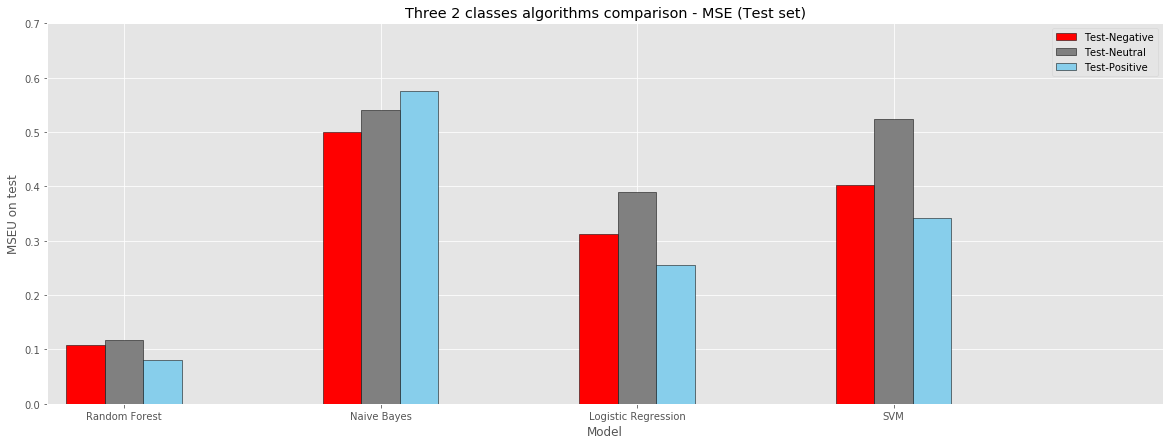

In [52]:
param = 'mse_test'
test_neg = [model_stats[algo][-1][param] for algo in model_objects if 'summary' in model_stats[algo]]
test_neutral = [model_stats[algo][0][param] for algo in model_objects if 'summary' in model_stats[algo]]
test_pos = [model_stats[algo][1][param] for algo in model_objects if 'summary' in model_stats[algo]]

# Plot a bar plot of ausc on validation and test
plt.figure(figsize=(20,7))
bar_width = 0.15

#train_neg_plot = plt.bar(np.arange(0,len(train_neg)), train_neg, width=bar_width, color='r', hatch='\\',edgecolor='black')
test_neg_plot = plt.bar(np.arange(0,len(test_neg)), test_neg, width=bar_width, color='r',edgecolor='black')

#train_neutral_plot = plt.bar(np.arange(2*bar_width,len(train_neutral)), train_neutral, width=bar_width, color='grey', hatch='\\',edgecolor='black')
test_neutral_plot = plt.bar(np.arange(1*bar_width,len(test_neutral)), test_neutral, width=bar_width, color='grey',edgecolor='black')

#train_pos_plot = plt.bar(np.arange(4*bar_width,len(train_pos)), train_pos, width=bar_width, color='skyblue', hatch='\\',edgecolor='black')
test_pos_plot = plt.bar(np.arange(2*bar_width,len(test_pos)), test_pos, width=bar_width, color='skyblue',edgecolor='black')

plt.title('Three 2 classes algorithms comparison - MSE (Test set)')
plt.ylabel('MSEU on test')
plt.xlabel('Model')
plt.xticks(np.arange(1.0*bar_width,len(test_pos)), [algo for algo in model_objects if 'summary' in model_stats[algo]])
plt.xlim([-bar_width, len(test_neg)+0.2])
plt.ylim([0.0,0.7])
# plt.legend([train_neg_plot,train_neutral_plot, train_pos_plot, 
#            test_neg_plot, test_neutral_plot, test_pos_plot], ['Train-Negative', 'Train-Neutral','Train-Positive','Test-Negative', 'Test-Neutral','Test-Positive'], loc='upper right')
plt.legend([test_neg_plot, test_neutral_plot, test_pos_plot], ['Test-Negative', 'Test-Neutral','Test-Positive'], loc='upper right')
plt.show()

In [53]:
for algo in model_stats:
    # Add a name to each algorithm (required for plot_multiple_ROC function)
    model_stats[algo]['name'] = algo

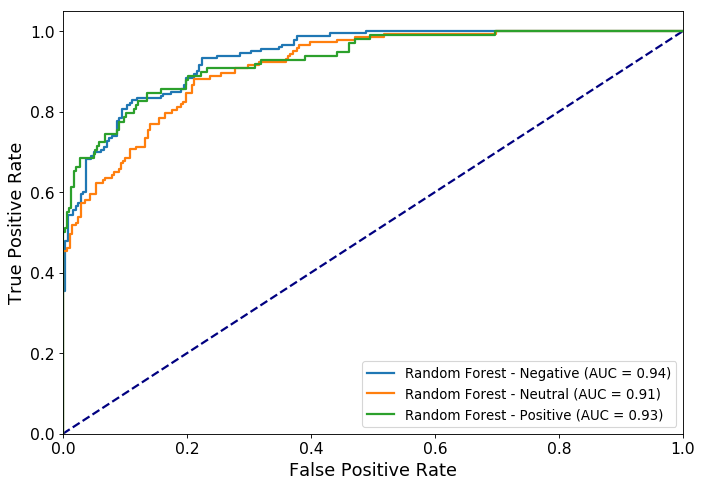

In [48]:
rel_stats = [model_stats['Random Forest'][rel_class] for rel_class in classes]
ml_model.plot_multiple_ROC(rel_stats)

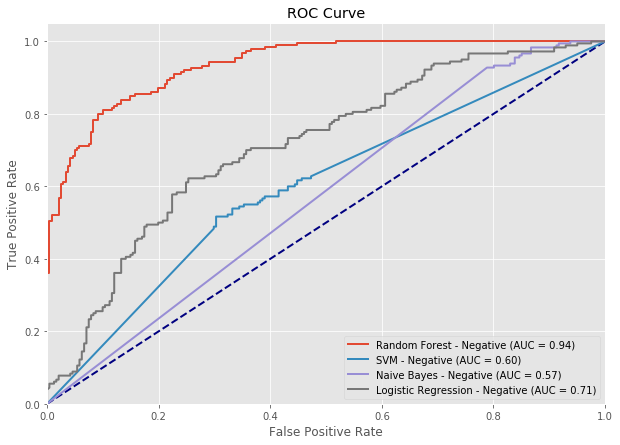

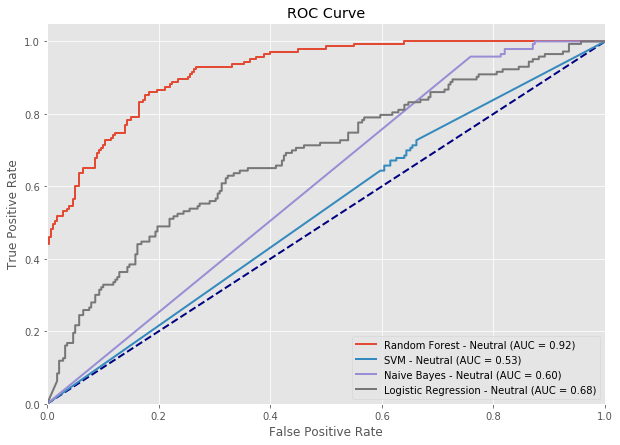

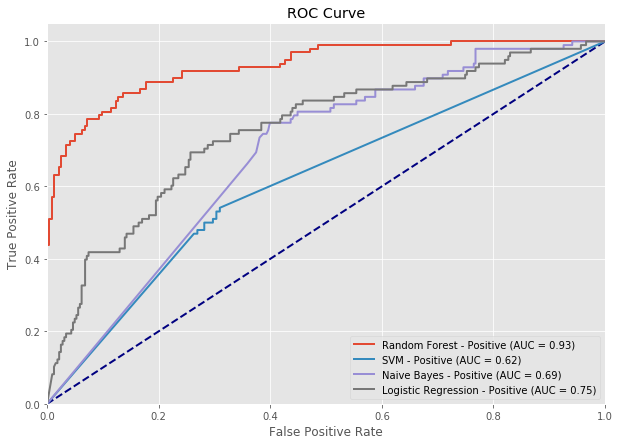

In [54]:
for rel_class in classes:
    # Take all ruc information regarding to a specific class (each has own ruc curve)
    rel_stats = [model_stats[algo][rel_class] for algo in model_stats if rel_class in model_stats[algo]]
    ml_model.plot_multiple_ROC(rel_stats)

## Benchmark
There is no available open-source algorithm for sentiment analysis in our domain, nor algorithm that considers parties.<br>
We will compare our algorithm with NLTK sentiment analysis tool (used in our model), and TextBlob sentiment analysis tool.

In [55]:
if config['bench_from_pickle']:
    df_bench = pd.read_pickle('../../data/classifiers/df_bench.pkl')
else:
    if config['target']=='support':
        df_bench = df[['text','tokenized_text',config['target']]]
        df_bench['nltk_vader'] = df_bench.text.progress_apply(lambda x: np.round(nlp_features.analyze_sentiment(x),0))
        df_bench['TextBlob'] = df_bench.text.progress_apply(lambda x: np.round(nlp_features.analyze_sentiment_TextBlob(x),0))

In [56]:
if not config['bench_from_pickle']:
    df_bench.to_pickle('df_bench.pkl')

#### NLTK results

In [57]:
labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
          'relevance': {'names': ['Not relevant', 'Relevant', 'Ignore'], 'values': [0,1,2]}}

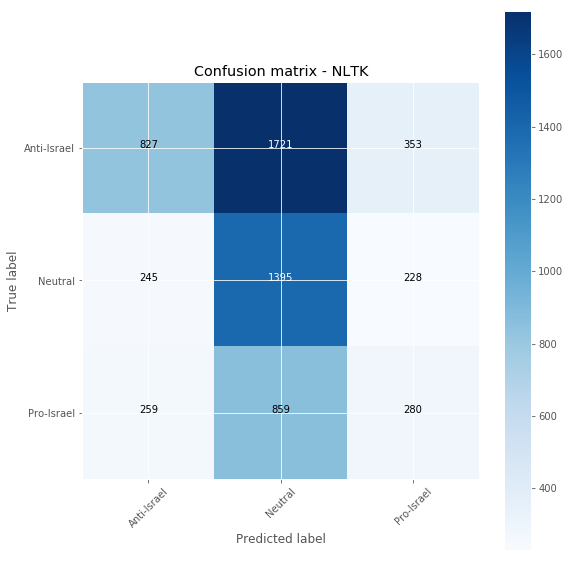

Accuracy on All: 0.41


In [58]:
ml_model.plot_confusion_matrix(list(df_bench.nltk_vader), list(df_bench.support), 'NLTK', 'All', labels[config['target']])
# calculate accuracy
accuracy_bench = metrics.accuracy_score(list(df_bench.support), list(df_bench.nltk_vader), normalize=True)

#### TextBlob results

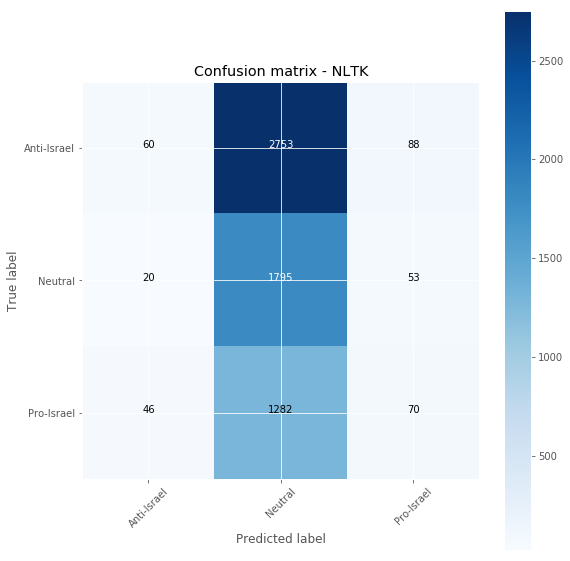

Accuracy on All: 0.31


In [59]:
ml_model.plot_confusion_matrix(list(df_bench.TextBlob), list(df_bench.support), 'NLTK', 'All', labels[config['target']])
# calculate accuracy
accuracy_bench = metrics.accuracy_score(list(df_bench.support), list(df_bench.TextBlob), normalize=True)